In [1]:
from mvcl.config import config
from mvcl.model import MetaVisualLearner
from mvcl.primitives import *
from rinarak.domain import Domain, load_domain_string

[Taichi] version 1.7.0, llvm 15.0.7, commit 7b58b0ff, osx, python 3.9.13


[I 01/27/24 11:42:31.193 6095716] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


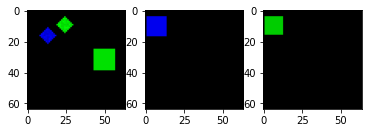

In [2]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets.sprites_base_dataset import SpritesBaseDataset
from datasets.sprites_meta_dataset import SpritesMetaDataset
domain_parser = Domain("mvcl/base.grammar")
meta_domain_str = f"""
(domain meta_demo)
(:type
    object - vector[float,100]
    position - vector[float,2]
    color - vector[float, 64]
    category
)
(:predicate
    color ?x-object -> vector[float,100]
    shape ?x-object -> vector[float,100]

    red ?x-color -> boolean
    blue ?x-color -> boolean
    green ?x-color -> boolean

    square ?x-shape -> boolean
    circle ?x-shape -> boolean
    diamond ?x-shape -> boolean
)
(:derived
    is-good ?x-color expr: (??f ?x)
)
(:constraint
    (color: red blue green)
    (shape: square circle diamond)
)
"""
domain = load_domain_string(meta_domain_str, domain_parser)
batch_size = 3
base_dataset = SpritesBaseDataset("train")
base_loader = DataLoader(base_dataset, batch_size = batch_size, shuffle = True)

# [visualize the datsets, show some samples]
for sample in base_loader: sample;break;
fig = plt.figure("visualize data")
for b in range(batch_size):
    ax = fig.add_subplot(1,batch_size,b+1)
    ax.imshow(sample["img"][b].permute(1,2,0))


In [3]:
# [Create the Demo Model]
model = MetaVisualLearner(domain, config)
model.load_state_dict(torch.load("checkpoints/KFT_backup.pth"))

color_mapper = nn.Linear(132,100)
shape_mapper = nn.Linear(132,100)

model.implementations["color"] = color_mapper
model.implementations["shape"] = shape_mapper

# [Pre-define some concept mapper]
color = Primitive.GLOBALS["color"]
color.value = lambda x: {**x, "features": x["model"].get_mapper("color")(x["features"])}
shape = Primitive.GLOBALS["shape"]
shape.value = lambda x: {**x, "features": x["model"].get_mapper("shape")(x["features"])}

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch_sparse/storage.py:14: UserWarning: `layout` argument unset, using default layout "coo". This may lead to unexpected behaviour.
  warnings.warn('`layout` argument unset, using default layout '


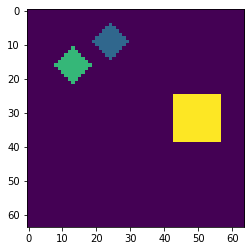

In [4]:
# [Take the Demo dataset sample as input]
ims = sample["img"]
masks = sample["masks"]

plt.figure("input-img")
plt.imshow(ims[0].permute(1,2,0))
plt.savefig("outputs/input_image.png")
plt.cla()
plt.imshow(masks[0])
plt.savefig("outputs/gt_masks.png")

outputs = model.perception(ims, masks.long().unsqueeze(1))

# save the results for the test run


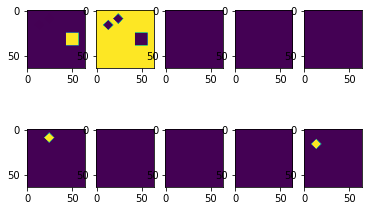

In [5]:
all_masks = outputs["masks"]
alives = outputs["alive"]
fig = plt.figure("masks"); b = 0
for i in range(all_masks.shape[-1]):
    ax = fig.add_subplot(2,5,1+i)
    ax.imshow(all_masks[b,:,:,i] * alives[b,i])
plt.savefig("outputs/predict_masks.png")

In [16]:
backbone_features = outputs["features"]
context = {
        "end":logit(alives[b].squeeze(-1)),
        "masks": logit(all_masks[b].permute(2,0,1).flatten(start_dim = 1, end_dim = 1)),
        "features": backbone_features[b].flatten(start_dim = 0, end_dim = 1),
        "model": model
}

# there is an object has red shape
p = Program.parse(f"""
        (exists
            (intersect
                (exists
                    (Pr (color (expand (scene $0)) ) blue) 
                )
                (scene $0)
            )
        )
    """)

questions = sample["questions"]
programs = sample["programs"]
answers = sample["answers"]
numbers = [str(i) for i in range(0,10)]

#p = Program.parse("(expand (scene $0))")
loss = 0.0
for b in range(len(programs[0])):
    for program_idx in range(len(programs)):
        question = questions[program_idx][b]
        program = programs[program_idx][b]
        answer = answers[program_idx][b]
        p = Program.parse(program)
        output = p.evaluate({0:context})
        if answer in ["yes", "no"]:
            if answer == "yes":
                loss += -torch.log(output["end"].sigmoid())
            if answer == "no":
                loss += -torch.log(1 - output["end"].sigmoid())
        if answer in numbers:
            loss += (output["end"]-int(answer))**2
        print(question)
        print(output["end"].detach().numpy(),answer, loss.detach().numpy())
loss /= (b+1) * (program_idx + 1)



is there any object with color of blue
-2.0300002 yes 2.153399
is there any object with shape of square
-1.7320895 yes 1.8949856
is there any object with color of green and with shape of diamond
-2.6350923 yes 2.70435
how many objects with color of red are there?
0.93232864 0 0.8692367
how many objects with shape of square are there?
1.5032052 1 0.25321546
is there any object with color of green
-2.0512576 no 0.12095413
is there any object with shape of diamond
-1.3756496 no 0.22528161
is there any object with color of red and with shape of square
-3.311314 no 0.03581901
how many objects with color of green are there?
1.1392537 0 1.2978991
how many objects with shape of diamond are there?
2.0170858 0 4.068635
is there any object with color of blue
-2.0300002 no 0.12339875
is there any object with shape of square
-1.7320895 yes 1.8949856
is there any object with color of green and with shape of diamond
-2.6350923 no 0.06925768
how many objects with color of red are there?
0.93232864 0 0

In [ ]:
with open("outputs/logqa.txt","w") as log_file:
    for i in range(len(programs)):
        log_file.write(questions[i][0]+"\n")
        log_file.write(programs[i][0]+"\n")
        log_file.write(answers[i][0]+"\n")
        